**Librerías a Utilizar**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import torch.nn.functional as F

## Cálculo de la media y desviación estándar

Este bloque carga las imágenes en escala de grises y calcula la media y desviación estándar de los píxeles para utilizarlas en la normalización del dataset. Esto mejora la estabilidad y el rendimiento del modelo.


In [1]:
# Directorio de la data aumentada
myDir = 'Datos_Kanjis'

# Transformación para cargar las imágenes sin normalizar
transform_no_norm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.ToTensor()  # Convertir las imágenes a tensores (sin normalizar)
])

# Cargar dataset
dataset = torchvision.datasets.ImageFolder(
    root=myDir,
    transform=transform_no_norm
)

# Usar un DataLoader con batch_size pequeño para evitar consumo excesivo de memoria
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Inicializar variables para la media y desviación estándar
sum_pixels = 0.0
sum_squared_pixels = 0.0
num_pixels = 0

# Calcular media y varianza incrementalmente
for images, _ in data_loader:
    sum_pixels += images.sum()
    sum_squared_pixels += (images ** 2).sum()
    num_pixels += images.numel()

# Calcular media y desviación estándar
mean = sum_pixels / num_pixels
var = (sum_squared_pixels / num_pixels) - (mean ** 2)
std = torch.sqrt(var)

# Convertir a valores escalares
mean = mean.item()
std = std.item()

print(f"Media: {mean}, Desviación estándar: {std}")

Media: 0.27045583724975586, Desviación estándar: 0.20256973803043365


In [2]:
mean=0.27045583724975586
std=0.20256973803043365

Se guarda los valores obtenidos para futuras implementaciones.

In [3]:
ruta_del_archivo = 'mean.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(mean))
ruta_del_archivo = 'std.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(std))

## Preprocesamiento y división del dataset

En este bloque se aplican las transformaciones necesarias a las imágenes, incluyendo la conversión a escala de grises si no se realizó antes, asegurarse de que las imágenes sean 64x64, la conversión a tensor y la normalización utilizando la media y desviación estándar calculadas previamente.

Luego, el dataset se divide en dos conjuntos: **entrenamiento (80%)** y **prueba (20%)**, y se guardan para su uso posterior.


In [26]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((mean,), (std,)),  # Normalización
])

# Directorio de la data aumentada
myDir = 'Datos_Kanjis'

# Usar ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)

# Dividir el dataset en entrenamiento y validación
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

print("Data normalizada y almacenada")

Data normalizada y almacenada


Cargar la data almacenada anteriormente.

In [4]:
train_data=torch.load('train_dataset.pth', weights_only=False)
test_data=torch.load('test_dataset.pth', weights_only=False)

In [5]:
# Cargar los datos en batches, de esta manera no se satura la RAM
batch_size_train = 256
batch_size_test = 1024
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False, num_workers=4, pin_memory=True)

## Visualización de datos de prueba

Se muestran algunas imágenes del conjunto de prueba junto con el indice de las etiquetas reales para verificar que los datos se hayan cargado correctamente.


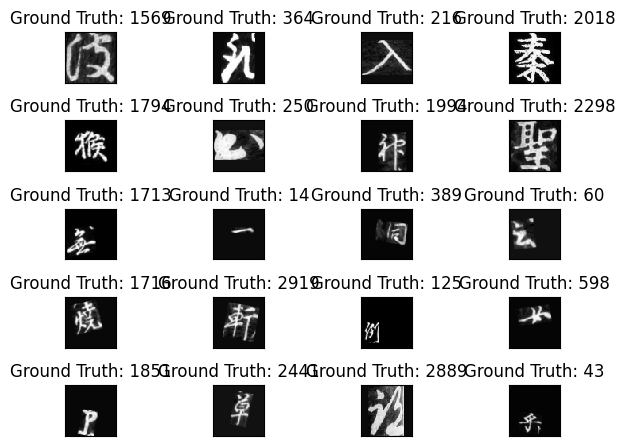

In [29]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Modelo desarrollado

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128*6*6, 4000)
        self.fc2 = nn.Linear(4000, 3490)

    def forward(self, x): # Entrada de 1 canal y 64x64 pixeles (1,64,64)
        x = self.conv1(x) # Salida (32,64-3+1,64-3+1)=(32,62,62)
        x = F.relu(x) # Salida (32,62,62)
        x = self.pool1(x) # Salida (32,62/2,62/2)=(32,31,31)
        x = self.conv2(x) # Salida (64,31-3+1,31-3+1)=(64,29,29)
        x = F.relu(x) # Salida (64,29,29)
        x = self.pool2(x) # Salida (64,29/2,29/2)=(64,14,14)
        x = self.conv3(x) # Salida (128,14-3+1,14-3+1)=(128,12,12)
        x = F.relu(x) # Salida (128,12,12)
        x = self.pool3(x) # Salida (128,12/2,12/2)=(128,6,6)
        x = self.drop1(x) # Salida (128,6,6)
        x = x.flatten(1) # Salida (128x6x6)
        x = self.fc1(x) # Salida (4000)
        x = F.relu(x) # Salida (4000)
        x = self.drop2(x) # Salida (4000)
        x = self.fc2(x) # Salida (3832)
        x = F.log_softmax(x, dim=1)
        return x

## Entrenamiento del Modelo

In [7]:
def weights_init(layer_in): #Inicializacion de los pesos
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

Verificar dispositivo

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


En este bloque se inicializa el modelo y el optimizador. Si ya existe un modelo previamente entrenado, se carga su estado para continuar el entrenamiento o realizar inferencias.

Si se desea entrenar un nuevo modelo desde cero, se puede comentar la línea donde se carga el estado del modelo (`model.load_state_dict`).

In [9]:
# Definir modelo y enviarlo a GPU
model = Net().to(device)

# inicializar pesos (solo si quieres resetear antes de cargar)
model.apply(weights_init)

# Cargar pesos guardados
#model.load_state_dict(torch.load("modelo_kanji_3000_completo_200.pth", map_location=device))

# Definir optimizador después de cargar pesos
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


# Confirmar que el modelo esté en GPU
print(f"Modelo cargado en: {next(model.parameters()).device}")

Modelo cargado en: cuda:0


## Función de entrenamiento

In [10]:
# Inicializa un GradScaler para el uso de precisión mixta en CUDA (aceleración con menor consumo de memoria)
scaler = torch.amp.GradScaler('cuda')

# Lista para almacenar la pérdida en cada batch
train_losses = []

def train(epoch):
    model.train()  # Modelo en modo de entrenamiento
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Mover los datos a la GPU

        optimizer.zero_grad()  # Reinicio de Gradiente

        # Usa autocast para realizar cálculos en precisión mixta, mejorando rendimiento en GPU
        with torch.amp.autocast('cuda'):
            output = model(data)
            loss = F.nll_loss(output, target)  # Cálculo de la función de pérdida

        # Escala la pérdida para evitar problemas de precisión
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # Actualiza los parámetros del modelo
        scaler.update()

        # Guardar la pérdida en la lista
        train_losses.append(loss.item())

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

## Función de testeo

In [11]:
def test():
    model.eval() # Pone el modelo en modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        # Usa autocast para realizar cálculos en precisión mixta, mejorando rendimiento en GPU
        with torch.amp.autocast('cuda'):
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)
                # Calcula la pérdida total sumando todas las pérdidas individuales del batch
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                # Obtiene la predicción con el valor más alto en cada salida
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

    # Calcula la pérdida promedio dividiendo entre el número total de muestras
    test_loss /= len(test_loader.dataset)

     # Imprime los resultados de la evaluación: pérdida promedio y precisión
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



En este bloque se entrena el modelo por un número determinado de épocas, el cual se puede modificar según las necesidades. Si se carga un modelo previamente entrenado, este puede continuar su entrenamiento desde el punto donde se quedó.

In [16]:
import torch.nn.functional as F
# Inicio del modelo para el testeo
#test()
# Entrenamioento por epocas
n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/777984]	Loss: 0.286926
Train Epoch: 1 [5120/777984]	Loss: 0.280440
Train Epoch: 1 [10240/777984]	Loss: 0.175983
Train Epoch: 1 [15360/777984]	Loss: 0.224213
Train Epoch: 1 [20480/777984]	Loss: 0.212899
Train Epoch: 1 [25600/777984]	Loss: 0.220421
Train Epoch: 1 [30720/777984]	Loss: 0.370542
Train Epoch: 1 [35840/777984]	Loss: 0.349177
Train Epoch: 1 [40960/777984]	Loss: 0.289653
Train Epoch: 1 [46080/777984]	Loss: 0.249205
Train Epoch: 1 [51200/777984]	Loss: 0.210877
Train Epoch: 1 [56320/777984]	Loss: 0.292910
Train Epoch: 1 [61440/777984]	Loss: 0.210798
Train Epoch: 1 [66560/777984]	Loss: 0.340821
Train Epoch: 1 [71680/777984]	Loss: 0.259959
Train Epoch: 1 [76800/777984]	Loss: 0.250731
Train Epoch: 1 [81920/777984]	Loss: 0.196340
Train Epoch: 1 [87040/777984]	Loss: 0.219695
Train Epoch: 1 [92160/777984]	Loss: 0.171859
Train Epoch: 1 [97280/777984]	Loss: 0.230656
Train Epoch: 1 [102400/777984]	Loss: 0.196525
Train Epoch: 1 [107520/777984]	Loss: 0.185021
Train Epoch: 

In [25]:
torch.save(model.state_dict(), "modelo_kanji_3000_completo_200.pth")

## Funcion de Perdida

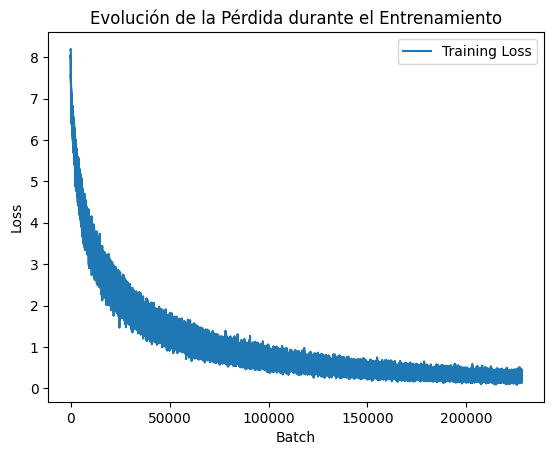

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.legend()
plt.show()


Kanjis en la pizarra

In [15]:
import numpy as np
unicode_carpetas=list(np.load("unicodes_kanji.npy"))

In [ ]:
caracteres=[]
for unicode in unicode_carpetas:
    char = chr(int(unicode[2:], 16))
    caracteres.append(char)

## Prueba con pizarra
Se realizó una pizarra interactiva, en esta dibujas un kanji y al hacer clic en "Predecir kanji" te muestra el kanji predicho, entonces al observar tanto el texto como el dibujo se sabe si se realizó de manera correcta, igualmente podemos guardar la imagen si vemos que es una predicción correcta con el botón de "Guardar imagen"

In [ ]:
import tkinter as tk
from tkinter import Button
import PIL.ImageGrab as ImageGrab
import cv2
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import numpy as np
import os

# Cargar el modelo entrenado
modelo = model.to(device)
modelo.eval()

# Crear la ventana
root = tk.Tk()
root.title("Pizarra de Kanji")

# Canvas de dibujo (ajustado para ser más grande que 28x28 para comodidad)
canvas_size = 256
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="black")
canvas.pack()

image1 = Image.new("RGB", (canvas_size, canvas_size), (0,0,0))
draw2 = ImageDraw.Draw(image1)

# Variables para dibujar
def start_drawing(event):
    canvas.old_x, canvas.old_y = event.x, event.y

def draw(event):
    x, y = event.x, event.y
    canvas.create_line(canvas.old_x, canvas.old_y, x, y, width=10, fill="white", capstyle=tk.ROUND, smooth=tk.TRUE)
    draw2.line([canvas.old_x, canvas.old_y, x, y], (255,255,255),width=10)
    canvas.old_x, canvas.old_y = x, y

canvas.bind("<Button-1>", start_drawing)
canvas.bind("<B1-Motion>", draw)

ruta_del_archivo = 'contador.txt'

with open(ruta_del_archivo, 'r') as file:
        contenido = file.read()
contador=int(contenido)
# Función para guardar la imagen y predecir
def guardar_y_predecir():
    image1.save('kanjis_dibujados/img1.png')
    # Convertir a tensor y normalizar
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean), (std,)),  # Normalizar las imágenes
])
    imagen_tensor = transform(image1).unsqueeze(0)  # Agregar dimensión batch

    # Hacer la predicción con el modelo
    imagen_tensor = imagen_tensor.to(device)
    salida = model(imagen_tensor)
    prediccion=salida.data.max(1, keepdim=True)[1].item()
    # Mostrar el resultado
    resultado_label.config(text=f"Predicción: {caracteres[prediccion]}")
    return prediccion

def guardar_imagen_con_nombre():
    global contador
    prediccion = guardar_y_predecir()  # Obtiene la predicción actual

    # Carpeta donde se guardarán las imágenes
    save_dir = 'kanjis_nuevos/'+f"{unicode_carpetas[prediccion]}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Crear la carpeta si no existe

    # Guardar la imagen con el nombre basado en la predicción
    save_path = os.path.join(save_dir, f"kanji_{contador}.png")
    image1.save(save_path)
    print(f"Imagen guardada como: {save_path}")
    contador+=1

    ruta_del_archivo = 'contador.txt'
    with open(ruta_del_archivo, 'w') as file:
        file.write(str(contador))

# Botón para guardar y predecir
boton_guardar = Button(root, text="Predecir Kanji", command=guardar_y_predecir)
boton_guardar.pack()

boton_guardar_imagen = Button(root, text="Guardar Imagen", command=guardar_imagen_con_nombre)
boton_guardar_imagen.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(root, text="Dibuja un Kanji y presiona 'Predecir Kanji'", font=("Arial", 14))
resultado_label.pack()

# Botón para limpiar la pizarra
# Función para limpiar el canvas y reiniciar la imagen
def limpiar_canvas():
    # Limpiar el canvas de dibujo
    canvas.delete("all")

    # Reiniciar la imagen asociada
    global image1, draw2
    image1 = Image.new("RGB", (canvas_size, canvas_size), (0, 0, 0))  # Nueva imagen en negro
    draw2 = ImageDraw.Draw(image1)  # Nuevo objeto ImageDraw para la imagen limpia

boton_limpiar = Button(root, text="Limpiar", command=limpiar_canvas)
boton_limpiar.pack()

root.mainloop()

## Pizarra de testeo
Esta pizarra es similar; sin embargo, se añade un botón de "Escribe un Kanji", este muestra un kanji al azar, entonces el usuario debe escribir el kanji y pulsar "Predecir Kanji", posteriormente a esto "Guardar Imagen", para este caso se muestra el Kanji a Predecir y el Kanji Predicho en pantalla, por lo que se sabría si se obtuvo un acierto o fallo, además al guradr las imágenes, la imágen sea correcta o errónea se guardará en la carpeta con el unicode del Kanji que se debió predecir, finalmente se puede realizar esto un número indefinido de veces y realizar un testeo para calcular el accuracy y otras métricas  del modelo en base al testeo, así mismo esto podría servir para volver a entrenar el modelo para que se ajuste más a trazos de ahora que a trazos antiguos.

In [ ]:
import tkinter as tk
from tkinter import Button
import PIL.ImageGrab as ImageGrab
import cv2
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import numpy as np
import os
import torch.nn.functional as F
# Cargar el modelo entrenado
modelo = model.to(device)
modelo.eval()

# Crear la ventana
root = tk.Tk()
root.title("Pizarra de Kanji")

# Canvas de dibujo (ajustado para ser más grande que 28x28 para comodidad)
canvas_size = 256
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="black")
canvas.pack()

image1 = Image.new("RGB", (canvas_size, canvas_size), (0,0,0))
draw2 = ImageDraw.Draw(image1)

# Variables para dibujar
def start_drawing(event):
    canvas.old_x, canvas.old_y = event.x, event.y

def draw(event):
    x, y = event.x, event.y
    canvas.create_line(canvas.old_x, canvas.old_y, x, y, width=10, fill="white", capstyle=tk.ROUND, smooth=tk.TRUE)
    draw2.line([canvas.old_x, canvas.old_y, x, y], (255,255,255),width=10)
    canvas.old_x, canvas.old_y = x, y

canvas.bind("<Button-1>", start_drawing)
canvas.bind("<B1-Motion>", draw)

ruta_del_archivo = 'contador.txt'

with open(ruta_del_archivo, 'r') as file:
        contenido = file.read()
contador=int(contenido)
# Función para guardar la imagen y predecir
def guardar_y_predecir():
    global valor
    image1.save('kanjis_dibujados/img1.png')

    # Convertir a tensor y normalizar
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean), (std,)),  # Normalizar las imágenes
])
    imagen_tensor = transform(image1).unsqueeze(0)  # Agregar dimensión batch

    # Hacer la predicción con el modelo
    imagen_tensor = imagen_tensor.to(device)
    salida = model(imagen_tensor)
    prediccion=salida.data.max(1, keepdim=True)[1].item()
    # Mostrar el resultado
    resultado_label.config(text=f"Escribe: {caracteres[valor]}\nPredicción: {caracteres[prediccion]}")
    return prediccion

def guardar_imagen_con_nombre():
    global contador
    global valor
    prediccion = guardar_y_predecir()  # Obtiene la predicción actual

    # Carpeta donde se guardarán las imágenes
    save_dir = 'kanjis_nuevos/'+f"{unicode_carpetas[valor]}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Crear la carpeta si no existe

    # Guardar la imagen con el nombre basado en la predicción
    save_path = os.path.join(save_dir, f"kanji_{contador}.png")
    image1.save(save_path)
    print(f"Imagen guardada como: {save_path}")
    contador+=1

    ruta_del_archivo = 'contador.txt'
    with open(ruta_del_archivo, 'w') as file:
        file.write(str(contador))

def azar():
    global valor
    valor= np.random.randint(0, len(caracteres))
    # Mostrar el resultado
    resultado_label.config(text=f"Escribe: {caracteres[valor]}")
    return valor

# Botón para guardar y predecir

boton_azar = Button(root, text="Escribe un Kanji", command=azar)
boton_azar.pack()

boton_guardar = Button(root, text="Predecir Kanji", command=guardar_y_predecir)
boton_guardar.pack()

boton_guardar_imagen = Button(root, text="Guardar Imagen", command=guardar_imagen_con_nombre)
boton_guardar_imagen.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(root, text="Dibuja un Kanji y presiona 'Predecir Kanji'", font=("Arial", 14))
resultado_label.pack()

# Botón para limpiar la pizarra
# Función para limpiar el canvas y reiniciar la imagen
def limpiar_canvas():
    # Limpiar el canvas de dibujo
    canvas.delete("all")

    # Reiniciar la imagen asociada
    global image1, draw2
    image1 = Image.new("RGB", (canvas_size, canvas_size), (0, 0, 0))  # Nueva imagen en negro
    draw2 = ImageDraw.Draw(image1)  # Nuevo objeto ImageDraw para la imagen limpia

boton_limpiar = Button(root, text="Limpiar", command=limpiar_canvas)
boton_limpiar.pack()

root.mainloop()

## Testeo
Con los kanjis guardados con la pizarra podemos realizar el testeo para calcular las métricas

In [9]:
myDir = 'kanjis_nuevos'

# Definir las transformaciones para las imágenes
transform = transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean,), (std,)),  # Normalizar las imágenes
])

# Usar ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)
# Cargar los datos en batches
batch_size_test2 = 200
test_loader2 = DataLoader(dataset, batch_size=batch_size_test2, shuffle=False)

Observamos parte de la data guardada

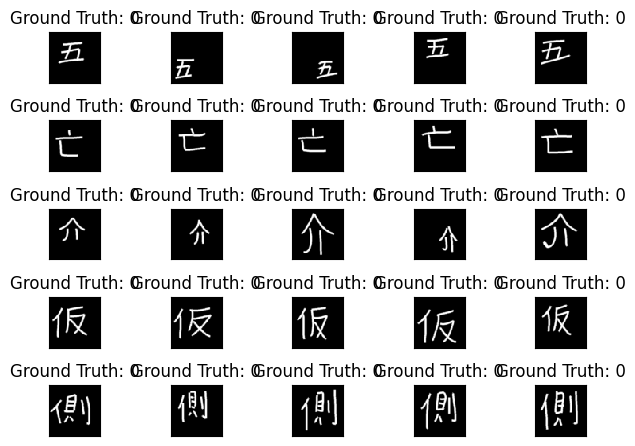

In [10]:
import matplotlib.pyplot as plt
# Let's draw some of the training data
examples = enumerate(test_loader2)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Predicciones de parte de la data de testeo

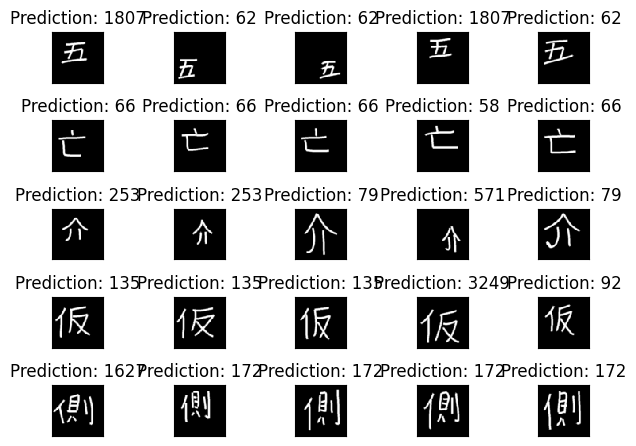

In [13]:
model.eval()
output = model(example_data.to(device))

fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

Obtenemos las predicciones y las transformamos a su Unicode

In [16]:
predicciones1=[]
for i in range(len(output)):
    predicciones1.append(output.data.max(1, keepdim=True)[1][i].item())
unicode_predicciones=[unicode_carpetas[i] for i in predicciones1]

Obtenemos los Unicode reales de las imágenes

In [21]:
import os
import numpy as np

ruta_principal = 'kanjis_nuevos' # Cambia esto a la ruta de tu carpeta principal

# Lista todas las carpetas dentro de la ruta principal
carpetas = [f for f in os.listdir(ruta_principal) if os.path.isdir(os.path.join(ruta_principal, f))]

# Crear el array con los nombres repetidos según la cantidad de archivos dentro
unicode_real = []

for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_principal, carpeta)
    num_archivos = len([f for f in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, f))])
    unicode_real=unicode_real+[carpeta] * num_archivos  # Repite el nombre según la cantidad de archivos

## Evaluación del modelo  

Con los labels reales y predichos, se calcularon las métricas de rendimiento: **accuracy, precision, recall y F1-score**. En este caso, los resultados obtenidos fueron:  

- **Accuracy:** 43.50%  
- **Precision:** 25.49%  
- **Recall:** 15.54%  
- **F1-score:** 17.72%  

A pesar de que estos valores aún son relativamente bajos, pueden deberse a varios factores. Uno de ellos es la diferencia en el trazado de los kanjis, ya que el dibujo en una pizarra puede no ser comparable con un trazado en lápiz y papel, donde el grosor del pincel varía. Además, la data utilizada proviene de **manuscritos antiguos**, lo que significa que algunos kanjis podrían haber cambiado con el tiempo o estar deformados, lo cual no refleja fielmente la escritura moderna.


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calcular accuracy
accuracy = accuracy_score(unicode_real, unicode_predicciones)
precision = precision_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
recall = recall_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
f1 = f1_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
print(f"Accuracy: {accuracy*100:.2f}%")  # Resultado entre 0 y 1
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 43.50%
Precision: 25.49%
Recall: 15.54%
F1-score: 17.72%
